In [24]:
import json

# Path to your JSON file
file_path = 'H_chain_data/H4/ham/1.json'

# Read the file
with open(file_path, 'r') as f:
    data = json.load(f)

# Now `data` is a Python dict (or list, depending on the JSON content)
print(data)

{'HF': [5.732753118300001, [[-3.17075881610808, 2.363192974641498e-12, -0.21266981414736685, 8.750246946291603e-12], [2.363179096853705e-12, -2.071703267909749, 7.898542930812973e-14, -0.305369960859904], [-0.2126698141473643, 7.858991235556485e-14, -1.0747221483192877, 3.7844036173025815e-12], [8.736252173069243e-12, -0.3053699608598988, 3.826793049111262e-12, -0.7951096141406181]], [[[[0.8245402519958781, -3.650976486089708e-13, 0.10067316106792616, -2.125009723175921e-12], [-3.649709396999122e-13, 0.620825722953005, -1.4103294785518647e-13, 0.12947582422442103], [0.10067316106792659, -1.406169536950745e-13, 0.343205024747776, -1.006910953752463e-12], [-2.1262706299270726e-12, 0.12947582422441367, -1.0177710288839658e-12, 0.29514381980972193]], [[-3.647949896339769e-13, 0.1423912254802414, -1.438664371571398e-13, 0.051119054056878596], [0.14239122548024138, -8.136650237877904e-13, -0.027144105876812107, -5.20114943473448e-13], [-1.438297690904997e-13, -0.027144105876812184, 4.7017665

In [44]:
import openfermion
from openfermion.transforms import get_fermion_operator, jordan_wigner, bravyi_kitaev
import itertools
import numpy as np
import torch

def add_spin_2bd(int_2bd):
    dim = int_2bd.shape[0]
    res = np.zeros((2*dim,2*dim,2*dim,2*dim))
    for i1,i2,i3,i4 in itertools.product(range(dim), repeat=4):
        for s1,s2,s3,s4 in itertools.product(range(2), repeat=4):
            if s1 == s4 and s2 == s3:
                res[i1*2+s1,i2*2+s2,i3*2+s3,i4*2+s4] = int_2bd[i1,i2,i3,i4]
    return res

def add_spin_1bd(int_1bd):
    dim = int_1bd.shape[0]
    res = np.zeros((2*dim,2*dim))
    for i1,i2 in itertools.product(range(dim), repeat=2):
        for s1,s2 in itertools.product(range(2), repeat=2):
            if s1 == s2:
                res[i1*2+s1,i2*2+s2] = int_1bd[i1,i2]
    return res

# do jordan wigner transformation
def JW_trans(Ham_const,int_1bd,int_2bd):
    # add spinint_2bd
    # note: openfermion and pyscf has different rules on int_2bd
    int_2bd = int_2bd.transpose((0,3,2,1))
    intop = openfermion.InteractionOperator(Ham_const,add_spin_1bd(int_1bd),add_spin_2bd(int_2bd)/2)
    #print(intop)
    fer = get_fermion_operator(intop)
    #print(fer)
    new_jw_hamiltonian = jordan_wigner(fer);
    return new_jw_hamiltonian

def LambdaQ(Ham_const,int_1bd,int_2bd,backend=torch):
    """
    Calculate the LambdaQ value for a given Hamiltonian.
    
    Parameters:
    Ham_const : torch.Tensor
        E0
        The constant part of the Hamiltonian.
    int_1bd : torch.Tensor
        h_{pq}
        The one-body interaction terms of the Hamiltonian.
    int_2bd : torch.Tensor
        g_{pqrs}
        The two-body interaction terms of the Hamiltonian.
        
    Returns: float
        \lambda_C+\lambda_T+\lambda_V^{\prime}
        where
            \lambda_C=\left|E0+\sum_p^N h_{p p}+\frac{1}{2} \sum_{p r}^N g_{p p r r}-\frac{1}{4} \sum_{p r}^N g_{p r r p}\right|,
            \lambda_T=\sum_{p q}^N\left|h_{p q}+\sum_r^N g_{p q r r}-\frac{1}{2} \sum_r^N g_{p r r q}\right|,
            \lambda_V^{\prime}=\frac{1}{2} \sum_{p>r, s>q}^N\left|g_{p q r s}-g_{p s r q}\right|+\frac{1}{4} \sum_{p q r s}^N\left|g_{p q r s}\right| .
    """

    trace = backend.trace
    einsum = backend.einsum
    abs = backend.abs
    sum = backend.sum

    h = int_1bd
    g = int_2bd
    N = h.shape[0]

    # λ_C = | sum_p h_pp + 1/2 sum_{p,r} g_pprr - 1/4 sum_{p,r} g_prrp |
    diag_h = trace(h)
    g_pprr = einsum('pprr->', g)
    g_prrp = einsum('prrp->', g)  # permute and sum over r → g[p,r,r,p]
    lambda_C = abs(diag_h + 0.5 * g_pprr - 0.25 * g_prrp+Ham_const)

    # λ_T = sum_{p,q} | h_pq + sum_r g_pqrr - 1/2 sum_r g_prrq |
    sum_r_g_pqrr = einsum('pqrr->pq', g)
    sum_r_g_prrq = einsum('prrq->pq', g)  # permute and sum over r → g[p,r,*,q]
    T_term = h + sum_r_g_pqrr - 0.5 * sum_r_g_prrq
    lambda_T = sum(abs(T_term))

    # λ_V' = 1/2 sum_{p>r, s>q} |g_pqrs - g_psrq| + 1/4 sum_{pqrs} |g_pqrs|
    indices = backend.arange(N)
    p, q, r, s = backend.meshgrid(indices, indices, indices, indices, indexing='ij')
    mask = (p > r) & (s > q)
    diff = g[p, q, r, s] - g[p, s, r, q]
    lambda_V_prime_1 = 0.5 * sum(abs(diff[mask]))
    lambda_V_prime_2 = 0.25 * sum(abs(g))
    lambda_V_prime = lambda_V_prime_1 + lambda_V_prime_2
    return lambda_C + lambda_T + lambda_V_prime


# test that lambda_Q == 1-norm of pauli decomposition
for method in ['l_opt','E_opt','HF','sto-3G']:

    Ham_const = data[method][0]
    int_1bd = np.array(data[method][1])
    int_2bd = np.array(data[method][2])
    qubit_ham = JW_trans(Ham_const,int_1bd,int_2bd)
    l_JW = sum(abs(coeff) for coeff in qubit_ham.terms.values())
    lambdaQ = LambdaQ(Ham_const,int_1bd,int_2bd,backend=np)
    assert abs(l_JW-lambdaQ) < 1e-5
    print(method,l_JW,lambdaQ)


l_opt 11.053974137905607 11.053974137905698
E_opt 11.255252489608921 11.255252489624596
HF 7.838791671123464 7.838791671285553
sto-3G 19.651493594826032 19.65149359482623


In [26]:

from openfermion.linalg import get_sparse_operator 
from scipy.sparse.linalg import eigsh
# Convert QubitOperator to sparse matrix (default ordering of qubits)
sparse_hamiltonian = get_sparse_operator(qubit_ham)

# Compute the lowest eigenvalue and eigenvector
# k=1 means we want only the ground state, which is the smallest eigenvalue
eigenvalue, eigenvector = eigsh(sparse_hamiltonian, k=1, which='SA')  # 'SA' = smallest algebraic

ground_energy = eigenvalue[0]
ground_state = eigenvector[:, 0]  # numpy vector of shape (2^n,)

print(f"Ground state energy: {ground_energy}")

Ground state energy: -1.0267898933161503


l_opt 11.053974137905607 11.053974137905698
-1.186734977707897
E_opt 11.255252489608921 11.255252489624596


/home/hewenhao/anaconda3/envs/ML_DFT/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


-1.1867349777079008
HF 7.838791671123464 7.838791671285553
-1.1649222016455518
sto-3G 19.651493594826032 19.65149359482623
-1.0267898933161508


/tmp/ipykernel_58394/70901122.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


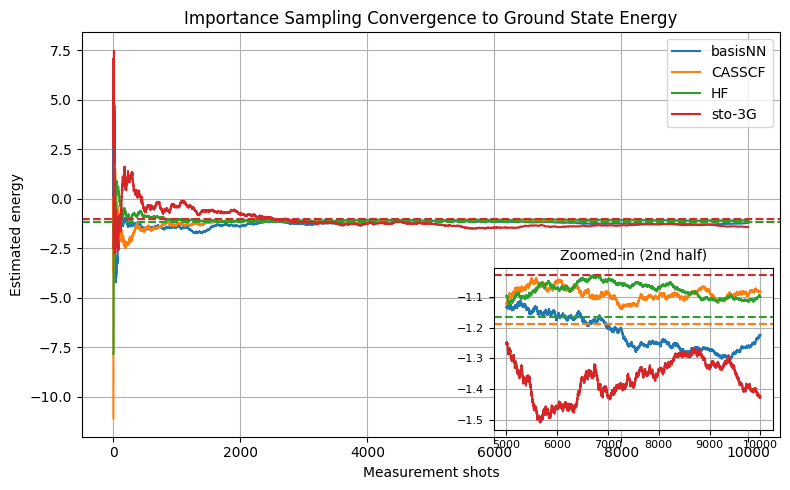

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from openfermion import QubitOperator
from openfermion.linalg import get_sparse_operator
from scipy.sparse.linalg import eigsh
import random

def estimate_expectation_importance_sampling(hamiltonian, statevector, shots):
    terms = list(hamiltonian.terms.items())
    coeffs = np.array([abs(c) for _, c in terms])
    probs = coeffs / np.sum(coeffs)

    true_expval = np.vdot(statevector, get_sparse_operator(hamiltonian) @ statevector).real

    estimates = []
    running_avg = []

    n_qubits = int(np.log2(len(statevector)))

    for _ in range(shots):
        idx = np.random.choice(len(terms), p=probs)
        pauli_term, coeff = terms[idx]
        op = get_sparse_operator(QubitOperator(pauli_term), n_qubits=n_qubits)
        measured = np.vdot(statevector, op @ statevector).real
        scaled = coeff / probs[idx] * measured
        #print(idx,measured,scaled)
        estimates.append(scaled)
        running_avg.append(np.mean(estimates))

    return running_avg, true_expval

methods = ['l_opt','E_opt','HF','sto-3G']
name = ['basisNN','CASSCF','HF','sto-3G']

plt.figure(figsize=(8, 5))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
methods = ['l_opt', 'E_opt', 'HF', 'sto-3G']

ax = plt.gca()
inset_ax = inset_axes(ax, width="40%", height="40%", loc="lower right")  # 👈 changed position

for i, method in enumerate(methods):
    color = colors[i % len(colors)]

    Ham_const = data[method][0]
    int_1bd = np.array(data[method][1])
    int_2bd = np.array(data[method][2])
    qubit_ham = JW_trans(Ham_const, int_1bd, int_2bd)

    l_JW = sum(abs(coeff) for coeff in qubit_ham.terms.values())
    lambdaQ_val = LambdaQ(Ham_const, int_1bd, int_2bd, backend=np)
    print(method, l_JW, lambdaQ_val)

    H_sparse = get_sparse_operator(qubit_ham)
    eigval, eigvec = eigsh(H_sparse, k=1, which='SA')
    ground_energy = eigval[0]
    ground_state = eigvec[:, 0]

    convergence, true_val = estimate_expectation_importance_sampling(qubit_ham, ground_state, shots=10000)
    print(true_val)

    ax.plot(convergence, label=name[methods.index(method)], color=color)
    ax.axhline(true_val, linestyle='--', color=color)

    # Inset plot (from middle to end)
    mid = len(convergence) // 2
    inset_ax.plot(range(mid, len(convergence)), convergence[mid:], color=color)
    inset_ax.axhline(true_val, linestyle='--', color=color)

# Main plot settings
ax.set_xlabel('Measurement shots')
ax.set_ylabel('Estimated energy')
ax.set_title('Importance Sampling Convergence to Ground State Energy')
ax.legend()
ax.grid(True)

# Inset settings
inset_ax.set_title('Zoomed-in (2nd half)', fontsize=10)
inset_ax.tick_params(labelsize=8)
inset_ax.grid(True)

plt.tight_layout()
plt.show()